In [1]:
%pylab inline

import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
import re

from scipy.optimize import fmin
from scipy.stats import gamma, beta
import numpy as np

sns.set_style('ticks')
sns.set_context('talk')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 2000)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_current_los(d):
    """Handy utility function to help you figure out the LOS for patients who haven't been discharged."""
    now = datetime.now()
    now = datetime(now.year, now.month, now.day)
    return(now - d).total_seconds() / 86400.0

def gamma_from_q(l, u, quantiles_percent=0.95):
    def loss(params):
        a, b = params
        lq = (1 - quantiles_percent) / 2
        uq = 1 - lq
        return ( (gamma.cdf(l, a, scale=b) - lq)**2 + (gamma.cdf(u, a, scale=b) - uq)**2 )

    start_params = (5, 5)
    fit = fmin(loss, start_params, disp=0)
    return fit

def beta_from_q(l, u, quantiles_percent=0.95):
    def loss(params):
        a, b = params
        lq = (1 - quantiles_percent) / 2
        uq = 1 - lq
        return ( (beta.cdf(l, a, b) - lq)**2 + (beta.cdf(u, a, b) - uq)**2 )

    start_params = (1, 1)
    fit = fmin(loss, start_params, disp=0)
    return fit

def plot_prior(lower, upper, dist=None, kind='gamma', max_val=100):
    """Plot priors for inspection.
    
    kind: 'gamma' or 'beta'
    """
    from_q, pdf = gamma_from_q, lambda x, a, scale: gamma.pdf(x, a, scale=scale), 
    if kind == 'beta':
        from_q, pdf, max_val = beta_from_q, lambda x, a, b: beta.pdf(x, a, b), 1
    print(f'lower: {lower}, upper: {upper}')
    params = from_q(lower, upper)
    fig, ax = plt.subplots(1,1, figsize=(7, 3.5))
    x = np.linspace(0, max_val, max_val*100)
    ax.plot(x, pdf(x, params[0], params[1]))
    ax.axvline(lower,ls='--')
    ax.axvline(upper,ls='--')
    if dist:
        ax2 = ax.twinx()
        pd.Series(dist).hist(ax=ax2, alpha=0.5)
        ax.set_xlim(tuple(np.percentile(dist, [0.1, 99.9])))
    print('Distribution: parameter 1: {}, parameter 2: {}'.format(params[0], params[1]))

## Creating a prior for social distancing

Let's say you want to use some published social distancing data to create a better informed prior on this parameter? One such source of data might be [Google's COVID-19 mobility data](https://github.com/kurtmaia/google_covid_data/blob/master/regionLevel.csv).

lower: 0.25, upper: 0.45
Distribution: parameter 1: 29.629392620168048, parameter 2: 55.85642665969445


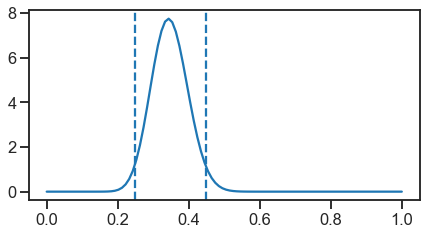

In [3]:
plot_prior(0.25, 0.45, kind='beta')

You can now use these parameters as input to BayesCHIME's [`logistic_L`](https://github.com/pennsignals/chime_sims/blob/240bcc10ed896e2c5ab6d13281d632b8490320b1/data/CCH_parameters.csv#L18) parameters.

## Creating a prior for mean hospital LOS
We have emprical data that can be used to estimate the prior distruibution for hospital LOS. If we gather data on the LOS of all current and past COVID-19 patients at our hospitals we can use survival analysis to estimate the true distribution of LOS means to create a data informed prior for our model.

In [4]:
survival_data = pd.read_csv('LOS_survival.csv')
survival_data.head()

,LOS,Observed
0,5.086805,True
1,8.184028,True
2,8.976389,True
3,10.161805,True
4,2.092361,True


* **LOS** should be the actual LOS for discharged patients and the censored (up till today) LOS for in-house patients
* **Observed** is a boolean to indicate if the patient has already been discharged (discharged == True, in-house == False)

In [5]:
T = survival_data["LOS"]
E = survival_data["Observed"]

In [7]:
from lifelines import WeibullFitter, KaplanMeierFitter

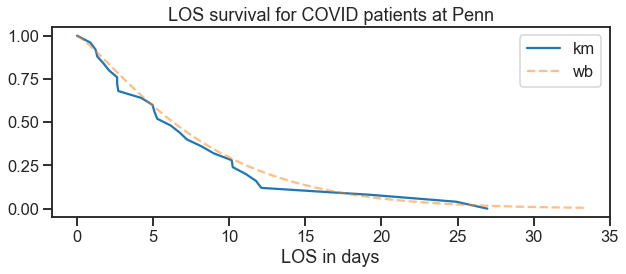

In [8]:
timeline = np.linspace(0, 100, 400) # assume max LOS of 100 days
kmf = KaplanMeierFitter().fit(T, event_observed=E)
wbf = WeibullFitter().fit(T, E, timeline=timeline, label='WeibullFitter')

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
ax.plot(kmf.survival_function_, label='km')
ax.plot(wbf.survival_function_.head(134), label='wb', alpha=0.5, ls='--')
ax.set_title('LOS survival for COVID patients at Penn')
ax.set_xlabel('LOS in days')
_ = ax.legend(loc=0)

The Weibull survival curve is pretty easy to sample from as follows... keep drawing samples till the mean converges (around 2k for my data)

In [9]:
means = []
while len(means) < 2000:
    for i in range(10):
        samps_probs = np.random.uniform(size=survival_data.shape[0])
        samps = []
        for a in samps_probs:
            samps.append(wbf.survival_function_[wbf.survival_function_['WeibullFitter'] <= a].index[0])
        means.append(np.mean(samps))
    mm = np.mean(means)
    print(f'{mm:.3f}', end=' ')

7.867 7.995 8.162 8.016 8.029 8.126 8.129 7.992 7.924 7.832 7.862 7.906 7.952 7.965 7.974 7.943 7.898 7.972 7.947 7.955 7.958 7.958 7.949 7.970 7.952 7.937 7.907 7.916 7.918 7.913 7.921 7.900 7.897 7.917 7.937 7.941 7.961 7.958 7.983 7.997 8.006 8.019 8.021 8.036 8.048 8.041 8.038 8.036 8.060 8.067 8.068 8.067 8.048 8.045 8.035 8.033 8.030 8.024 8.019 8.019 8.017 8.024 8.026 8.026 8.027 8.022 8.022 8.023 8.025 8.033 8.031 8.026 8.035 8.035 8.041 8.039 8.044 8.048 8.054 8.045 8.045 8.051 8.058 8.064 8.069 8.064 8.054 8.054 8.051 8.054 8.053 8.049 8.046 8.046 8.041 8.038 8.038 8.039 8.042 8.035 8.032 8.035 8.033 8.031 8.037 8.042 8.038 8.042 8.042 8.045 8.047 8.050 8.050 8.057 8.050 8.053 8.049 8.050 8.055 8.058 8.060 8.061 8.063 8.064 8.060 8.058 8.057 8.057 8.058 8.054 8.047 8.047 8.042 8.042 8.038 8.034 8.031 8.034 8.040 8.041 8.041 8.040 8.041 8.043 8.042 8.037 8.032 8.035 8.035 8.034 8.034 8.031 8.033 8.030 8.035 8.034 8.033 8.031 8.028 8.022 8.019 8.020 8.023 8.029 8.030 8.032 8.03

lower: 5.684210526315789, upper: 10.8578947368421
Distribution: parameter 1: 37.17271413875237, parameter 2: 0.21698533848262633


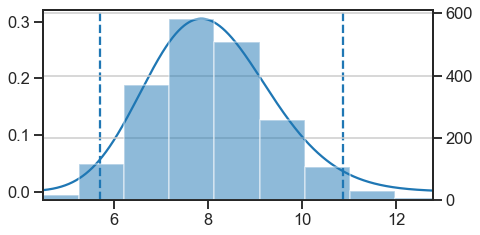

In [10]:
lower, upper = tuple(np.percentile(means, [2.5, 97.5]))
plot_prior(lower, upper, dist=means)

You can now use these parameters as input to BayesCHIME's [`hosp_LOS`](https://github.com/pennsignals/chime_sims/blob/240bcc10ed896e2c5ab6d13281d632b8490320b1/data/CCH_parameters.csv#L9) parameters.<br>
*Note: Don't forget to also update you prior on `ICU_LOS` if needed. Unlike CHIME, ICU_LOS only counts the amount of time spent in the ICU for patients who require ICU* 